In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
import matplotlib as mpl

# Plotting syle
plt.style.use('dark_background')

# Plotting functions
def clean_ax(ax, clean_all : bool = False, inverted : bool = False):
    """
    Cleans the borders of a matplotlib.axis object.
    Parameters
    ----------
    ax: matplotlib.axis
        axis object to be modified
    clean_all: boolean (default = False)
        whether to clean the entire boundary
    inverted: boolean (default = False)
        whether to clean bottom and right borders
    """
    if clean_all:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)    
        ax.spines['bottom'].set_visible(False)
    elif inverted:
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return ax

# Introduction to Survival Analysis

In this notebook we will take a quick review of the collection of statistical techniques known as **survival analysis**. In survival analysis, we are generally interested in the time until an event happens. Thus, the response variable is usually called **survival time**, **failure time** or **event time**. 

Some examples of such situations are:
* Survival time of a patient after a surgery or treatment.
* Time until a former prisoner goes back to jail.
* The time taken for a farm to experience its first case of an exotic disease.
* The time until a person gets inquired at Serasa.
* ... or the time until a person (Data Scientist) dies.

## Censoring
When analyzing (accompanying) subjects on a survival experiment (such as the ones listed above) typically some subjects will have **censored** survival times. That is, the survival times of such subjects are actually not observed. This is the case when dealing with death as the event, for instance. In other words, censoring occurs when we are unable to collect a complete set of data for a subject (because he dropped out of the study, for instance). 
* *Time-to-censoring* $C$, is the duration between the start event and the censoring.
* *right-censoring*: censoring that occurs before the event, this is, no information could be collected about the event of interest for that subject.
* *left-censoring*: occurs when a person's true *survival* time is less that or equal to the time information was observed, e.g., time until COVID exposure.

Often, a dataset with right censoring would look like:

In [3]:
random_seed = 42
study_duration = 15

np.random.seed(seed = random_seed)
births = np.reshape(np.round(np.random.rand(8,1)* 10, 2), -1)
survival_df = pd.DataFrame({'birth': births,
                            'death': np.reshape(np.round([x +np.random.random()*20 for x in births],2), -1) })
                          
survival_df.loc[survival_df.death > study_duration, 'death'] = np.nan
survival_df['status'] = 1 - survival_df.death.isna().astype(int)
# Censoring an arbitrary observation
idx = survival_df[~survival_df['death'].isna()].index[-1]
survival_df.at[idx, 'status'] = 0

survival_df

,birth,death,status
0,3.75,NaN,0
1,9.51,NaN,0
2,7.32,7.73,1
3,5.99,NaN,0
4,1.56,NaN,0
5,1.56,5.81,1
6,0.58,4.22,1
7,8.66,12.33,0


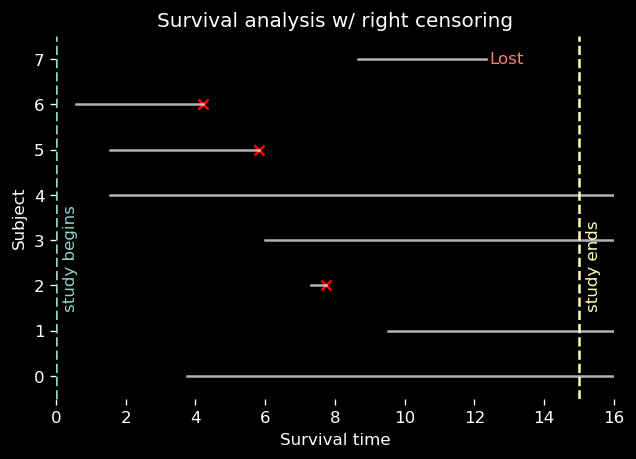

In [4]:
f, ax = plt.subplots(dpi =120)
# Fix plot limits
ax.set_xlim([0, 16])
ax.set_ylim([-0.5, 7.5])
xlim = ax.get_xlim()
xlim_rng = xlim[1]-xlim[0]
# Study reference initial and final points
ax.axvline(x=0, linestyle = '--', c= 'C0')
ax.annotate('study begins', xy = (0.2, 1.5), c = 'C0', rotation = 90)
ax.axvline(x=15, linestyle = '--', c= 'C1')
ax.annotate('study ends', xy = (15.2, 1.5), c = 'C1', rotation = 90)

# Survival lines
for i, j in survival_df.iterrows():
    if j['status'] != 0:
        ax.axhline(y = i, 
                    xmin = j['birth']/xlim[1], 
                    xmax = j['death']/xlim[1],
                    alpha = 0.7)
        ax.scatter(x = j['death'], y = i, marker = 'x', c = 'r')
    else:
        if not np.isnan(j['death']):
            ax.axhline(y = i, 
                        xmin = j['birth']/xlim[1], 
                        xmax = j['death']/xlim[1],
                        alpha = 0.7)
            ax.annotate( 'Lost', xy = (j['death']+0.1, i-0.1), c = 'C3')
        else:
            ax.axhline(y = i, 
                        xmin = j['birth']/xlim[1],
                        alpha = 0.7)
clean_ax(ax, clean_all = True)
ax.set_ylabel('Subject')
ax.set_xlabel('Survival time')
ax.set_title('Survival analysis w/ right censoring')
plt.show()

In the above picture, subjects 2, 5 and 6 had actually suffered an event while subject 7's track was lost. This is, we do not know whether subject 7 has suffered an event or just his/her records disappeared for some reason (e.g. moving away from the the location where the study is being performed).
Note that in the case of studying a death event, the censoring considers unregisterd deaths, such as COVID-19 sub notification issues around the world.




## Describing time to event
Let us start with some terminology and definitions. 

> **Definition: [Survival Time]** Let $T \in \mathbb{R}^{+}$ be a random variable (survival time) and $t$ an particular arbitrary value for $T$. 

> **Definition: [Censor variable]** Let $d \in \{0,1\}$ be the response variable such that $d=1$ if the event has happened while $d=0$ in the case of censoring; This is, the event has not been observed whether because it has not happened or because we have lost track of the subject.


### Death density
When considering the time until an event happens (e.g. death) we can construct a histogram of the count of events as a function of time. In simple terms, we could fit a curve to this histogram (e.g. using Kernel Density Estimation) and produce a *death* probability density function $f(t)$. After normalization, at any given time $t$ the proportion of observed events in the population is given by:
$$F(t) = \int_{0}^{t}f(u)du,$$
the cumulative death distribution function. Essentially, we are assuming $T$ (time-to-event) to be a random variable with cumulative distribution function:
$$F(t) := \mathbb{P}(T \leq t)$$

To illustrate this, consider the following dataset:

In [5]:
!ls data/healthcare

colon.csv     lung.csv      stanford2.csv
kidney.xlsx   ovarian.csv   veteran.csv


In [6]:
df = pd.read_excel('data/ddrevisited_data_v1.xls')
df.head()

,order,ctryname,year,aclpcode,cowcode,cowcode2,qogctycode,qogctylett,qogctyyear,ccdcodelet,...,regime,tt,ttd,tta,flagc,flagdem,flagreg,agedem,agereg,stra
0,1,Afghanistan,1946,142,700.0,700,4,AFG,41946,AFG,...,5.0,0.0,0.0,0.0,1.0,1.0,1.0,18.0,18.0,0.0
1,2,Afghanistan,1947,142,700.0,700,4,AFG,41947,AFG,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,19.0,0.0
2,3,Afghanistan,1948,142,700.0,700,4,AFG,41948,AFG,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0
3,4,Afghanistan,1949,142,700.0,700,4,AFG,41949,AFG,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,21.0,0.0
4,5,Afghanistan,1950,142,700.0,700,4,AFG,41950,AFG,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,0.0


The dataset contains information about countries from 1946 to 2008. Thus, this is a right censored dataset. Among the information from countries there are two special columns named `bornyear` and `endyear` which stand for the years that a specific country (with that name) was born and was ended. We can use the countries' duration time as our survival time random variable.

In [7]:
survival_df = df.groupby('ctryname')[['bornyear', 'endyear']].first().reset_index()
survival_df['status'] = survival_df.endyear.apply(lambda x: 0 if x == 2008 else 1)
survival_df['duration'] = survival_df['endyear'] - survival_df['bornyear']
survival_df['q_duration'] = pd.qcut(survival_df.duration, q= 10)
survival_df.head()

,ctryname,bornyear,endyear,status,duration,q_duration
0,Afghanistan,1919.0,2008.0,0,89.0,"(71.7, 104.2]"
1,Albania,1912.0,2008.0,0,96.0,"(71.7, 104.2]"
2,Algeria,1962.0,2008.0,0,46.0,"(43.0, 48.0]"
3,Andorra,1993.0,2008.0,0,15.0,"(1.999, 17.0]"
4,Angola,1975.0,2008.0,0,33.0,"(24.2, 34.0]"


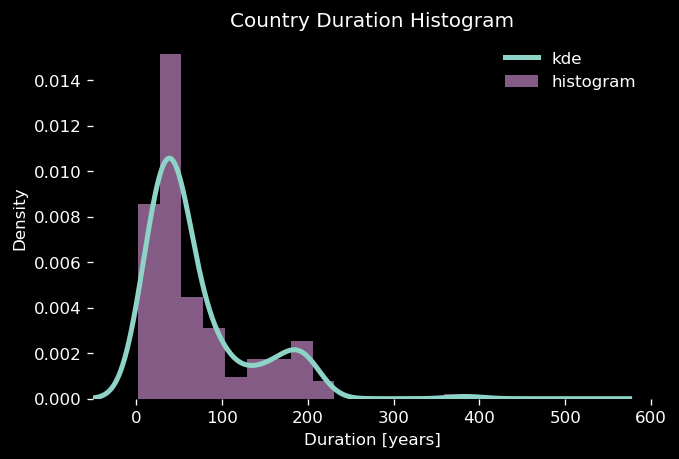

In [8]:
f, ax = plt.subplots(dpi = 120)
survival_df.duration.plot.kde(ax = ax, color = 'C0', linewidth = 3, label = 'kde')
survival_df.duration.plot.hist(density = True, ax = ax, color = 'C7', alpha = 0.7, label = 'histogram', bins = 15)
ax.legend(loc = 'best', frameon = False)
clean_ax(ax, clean_all = True)
ax.set_xlim([-50, 600])
ax.set_ylabel('Density')
ax.set_xlabel('Duration [years]')
ax.set_title('Country Duration Histogram')
plt.show()



### Survival function

>**Definition:** The survival function $S(t)$ gives the probability that a person survives longer than some specified time $t$, in other words:
>$$S(t):=\mathbb{P}(T > t)$$
Given a death density function $f(t)$. The area under the curve to the right of time $t$ is the proportion of subjects in the population who have survived past time $t$. We call this quantity $S(t)$ and it is given by:
$$S(t) = 1 - \int_{0}^{t}f(u)du = 1 - F(t).$$
The survival function is related an instantaneous risk rate which we introduce next.

### Instantaneous Hazard function

> **Definition:** The instantaneous rate at which a randomly-selected individual known to be alive at time $t$ will die at time $t+ \Delta t$ is called the conditional failure rate or instantaneous hazard, $\lambda(t)$. Given by:
>$$\lambda(t) = \lim_{\Delta t \rightarrow 0}\dfrac{\mathbb{P}(t\leq T < t + \Delta t | T \geq t  )}{\Delta t},$$
>where $\Delta t$ is an infinitesimal time interval.

Note that, in contrast to the *survival function* the *instantaneous hazard rate* focus on the event rather than surviving to the event. The above expression can be written as:
\begin{align*}
\lambda(t) &= \lim_{\Delta t \rightarrow 0} \dfrac{\mathbb{P}(t\leq T < t + \Delta t \cap T \geq t)}{\mathbb{P}(T \geq t)\Delta t}, \\
            &= \lim_{\Delta t \rightarrow 0} \dfrac{\mathbb{P}(t\leq T < t + \Delta t)}{S(t) \Delta t}, \\
            &= \lim_{\Delta t \rightarrow 0} \dfrac{f(t)\Delta t}{S(t)\Delta t}\\
            &= \dfrac{f(t)}{S(t)}.
\end{align*}
Where in the second line we have used the fact that $\mathbb{P}(t\leq T < t + \Delta t \cap T \geq t) = \mathbb{P}(t\leq T < t + \Delta t)$ and then we used the fact that for very small $\Delta t$ we can write $\mathbb{P}(t\leq T < t + \Delta t) \approx f(t) \Delta t$. In the last line: $f(t)$ is the *death density* and $S(t)$ is the survival function. 

Furthermore, by noting that:
$$\dfrac{d}{dt}S(t) = -f(t),$$
we can write for the hazard function:
$$\lambda(t) = -\dfrac{d}{dt}\log S(t)\;\;\; \text{or:  } \;\;S(t) = e^{-\int_{0}^{t}\lambda(u)du}$$

> **Example:** This relation allows us to analyze a very simple scenario, the one where the hazard risk does not change with time $t$. This is: $\lambda = c$, where $c$ is a constant value. Which leaves for the survival function:
>$$S(t) = e^{-c t}$$
>The above is straightforward to illustrate with a few code lines:

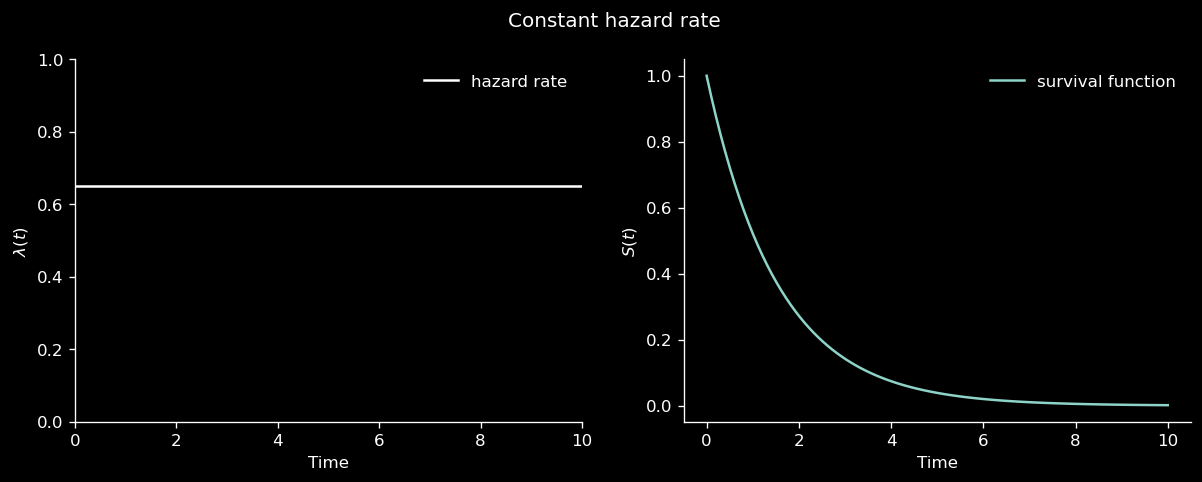

In [9]:
c = 0.65
x = np.linspace(0, 10, 100)
S = np.exp(- c * x)
f, ax = plt.subplots(1,2, dpi = 120, figsize = (12,4))
ax[0].axhline(y = c, xmin = x[0], xmax = x[-1], label = 'hazard rate')
ax[0].set_xlim([x[0], x[-1]])
clean_ax(ax[0])
ax[0].legend(loc = 'best', frameon = False)
ax[0].set_ylabel(r'$\lambda(t)$')
ax[0].set_xlabel('Time')
# Survival function
ax[1].plot(x, S, label = 'survival function')
ax[1].set_xlabel('Time')
ax[1].set_ylabel(r'$S(t)$')
ax[1].legend(loc = 'best', frameon = False)
clean_ax(ax[1])
f.suptitle('Constant hazard rate')
plt.show()

> **Definition:** It is also natural to define the *cumulative hazard function* as:
> \begin{align*}
 \Lambda(t) &:= \int_{0}^{t}\lambda(u) du \\
            & = - \int_{0}^{t} \dfrac{d}{du}\log S(u) du \\
            & = - \log S(t)
\end{align*}

So we can rewrite the survival and death density functions in terms of this cumulative hazard function
\begin{align*}
S(t) &= e^{-\Lambda(t)}\\
f(t) &= \lambda(t)e^{-\Lambda(t)}.
\end{align*}
Note that the hazard function might be of more intrinsic interest than the p.d.f. to a patient who had survived a certain time periotd and wanted to knwo something about their prognosis. There are also other reasons for introducing the hazard functions $\lambda(t)$ and $\Lambda(t)$:
* **Interpretability:** Suppose T denotes time from surgery for breast cancer
until recurrence. Then when a patient who had received surgery visits
her physician, she would be more interested in conditional probabilities
such as “Given that I haven’t had a recurrence yet, what are my chances
of having one in the next year” than in unconditional probabilities (as
described by the p.d.f.).
*  **Analytic Simplifications:** When the data are subject to right censoring,
hazard function representations often lead to easier analyses. For example, imagine assembling a cohort of $N$ patients who just have turned $50$
years of age and then following them for 1 year. Then if $d$ of the men
die during the year of follow-up, the ratio $d/N$ estimates the (discrete)
hazard function of $T$ =age at death. We will see that $\Lambda(·)$ has nice
analytical properties.
* **Modeling Simplifications:** For many biomedical phenomena, T is such
that $\lambda(t)$ varies rather slowly in t. Thus, $\lambda(·)$ is well-suited for modeling.

The **Expected Survival Time** or life expectancy is given by:
$$\mu := \mathbb{E}[T] = \int_{0}^{\infty} t f(t)  dt$$
after integrating by parts, and making use of the fact that $-f(t) = d/dt S(t)$, we get:
$$\mu = \int_{0}^{\infty}S(t)dt.$$



## The Likelihood Function for Censored Data
Suppose we have a *cohort* of $N$ observations governed by a survival function $S(t)$ with *death* density $f(t)$ and hazard $\lambda(t)$. If the $i$-th subject is observed at time $t_i$ and the subject died, its contribution to the likelihood function is:
$$L_i = f(t_i) = S(t_i)\lambda(t_i).$$
If the subject is alive at time $t = t_i$, all we know is that the survival time $T$ of subject $i$ exceeds $t_i$. The likelihood of this event is:
$$L_i = S(t_i),$$
the contribution to the likelihood of a censored observation.

Let $d_i\in \{0,1\}$ be the death indicator variable for the $i$-th observation, that takes the value $1$ if the subject died and $0$ otherwise. Then, we can write the likelihood function as:
$$\mathcal{L}= \prod_{i = 1}^{N}L_i = \prod_{i=1}^{N}\lambda(t_i)^{d_i}S(t_i).$$
This leaves for the log-likelihood:
$$\log\mathcal{L} = \sum_{i = 1}^{N}\left\{d_i\log\lambda(t_i)- \Lambda(t_i)\right\}.$$

> **Example:** Let us go back to our good old exponential distribution example. The hazard rate function is constant $\lambda(t)=\lambda$. Then, for the cumulative hazard we have $\Lambda(t) = \lambda t$. The log-likelihood then reads:
>$$\log\mathcal{L} = \sum_{i}^{N}\left\{d_i \log\lambda - \lambda t_i \right\},$$
>if $D = \sum_{i}^{N} d_i$ is the total number of deaths and $T= \sum_{i}^{N}t_i$ is the total observation time. We can write the log-likelihood as:
>$$\log \mathcal{L} = D \log\lambda - \lambda T.$$
>We obtain a score function by diferentiating this expression with respect to $\lambda$:
>$$u(\lambda) = \dfrac{d}{\lambda} - T,$$
>setting this score to zero gives the maximum likelihood estimator of the hazard:
>$$\hat{\lambda}_{ML} =\dfrac{D}{T} $$
>the total number of deaths divided by the total duration time, a.k.a. death rate. The expected information is obtained from:
>\begin{align*}
I(\lambda) &= -\dfrac{d^2}{d\lambda^2}\log\mathcal{L}\\
            &=\dfrac{D}{\lambda^2}.
\end{align*} 
> using the maximum likelihood estimate $\lambda_{ML}$ we get an estimator for the variance:
>$$\widehat{\text{var}}(\hat{\lambda})=\dfrac{D}{T^2},$$
> which is used as a confidence interval for $\lambda$.

## Approaches to Survival Analysis

### Estimating the Survival function
We could be tempted to estimate this quantity as:
$$\hat{S}_{\text{Naive}}(t) = \dfrac{n_s(t)}{n},$$
where $n_s(t)$ is the number of subjects surviving beyond $T=t$ and $n$ is the total number of subjects. But note that in the presence of censoring this estimator cannot be used since the numerator is not always defined. To see this consider the data in the example below: the subject indexed as `13` has a survival time $T=25$ days but the response variable `status` has a value of $0$ which means the observation was censored at the 25th day. For this subject we do not have information about the occurrence of the event. The only thing we know is that the event has not occurred for the 25 first days of observation, point at which we have lost track of the subject. This right censoring does not allow us to calculate the real number of surviving subjects, the numerator of the $\hat{S}_{\text{Naive}}(t)$ estimator.

>To illustrate the survival function estimation, we will use a dataset concerning **Veteran's Administration Lung Cancer Trial** dataset. It consists of a randomized trial of two treatment regimes for lung cancer. The dataset contains the following variables:
* Treatment: denotes the type of lung cancer treatment; standard and test drug.
* Celltype: denotes the type of cell involved; squamous, small cell, adeno, large.
* Karnofsky_score: is the Karnofsky score.
* Diag: is the time since diagnosis in months.
* Age: is the age in years.
* Prior_Therapy: denotes any prior therapy; none or yes.
* Status: denotes the status of the patient as dead or alive; dead or alive.
* Survival_in_days: is the survival time in days since the treatment.

In [10]:
df = pd.read_csv('data/healthcare/veteran.csv')
df.shape

(137, 8)

In [11]:
df.iloc[[11,5,32,13,23]]

,time,status,karno,diagtime,age,prior,trt,celltype
11,8,1,40,58,63,10,1,1
5,10,1,20,5,49,0,1,1
32,20,1,30,5,65,0,1,2
13,25,0,80,9,52,10,1,1
23,59,1,30,2,65,0,1,2


Consider our naive estimator $\hat{S}_{\text{Naive}}(t)$. From the above table, we can compute $\hat{S}_{\text{Naive}}(t=11)= \frac{3}{5}$. But we cannot compute $\hat{S}_{\text{Naive}}(t = 30)$ because we do not know whether subject number 4 (indexed `13`) is still alive at $t=30$, all we know is that the subject was still alive at $t = 25$.

### Kaplan-Meier Estimator
An estimator that can be used for right censored data (as it is our case) is the so called **Kaplan-Meier** estimator.
> **Definition: [Kaplan-Meier]** Let $d_i$ be the number of events at time $T=t_i$. Let also $n_i$ be the number of subjects *known to be survived*, this is, the number of subjects with no event or that are censored up to time $t_i$. The Kaplan-Meier estimator for the survival function is defined as:
>$$\hat{S}_{KM}(t) := \prod_{i:t_i\leq t}\left(1 - \dfrac{d_i}{n_i}\right)$$

In [12]:
from sksurv.nonparametric import kaplan_meier_estimator

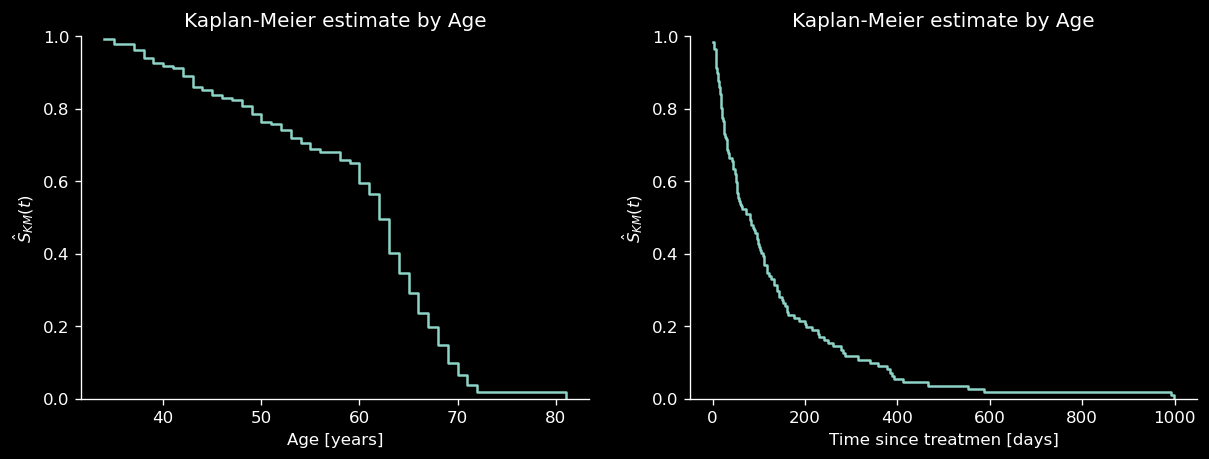

In [13]:
# Event variable
E = df['status']
x_age, y_age = kaplan_meier_estimator(E.astype(bool), df['age'])
x_time, y_time = kaplan_meier_estimator(E.astype(bool), df['time'])
f, ax = plt.subplots(1, 2, dpi = 120, figsize = (12, 4))
# By age
ax[0].step(x_age, y_age, where="post")
ax[0].set_ylim(0, 1)
clean_ax(ax[0])
ax[0].set_ylabel(r'$\hat{S}_{KM}(t)$')
ax[0].set_xlabel('Age [years]')
ax[0].set_title('Kaplan-Meier estimate by Age')
# By survival time in days since the treatment
ax[1].step(x_time, y_time, where="post")
ax[1].set_ylim(0, 1)
clean_ax(ax[1])
ax[1].set_ylabel(r'$\hat{S}_{KM}(t)$')
ax[1].set_xlabel('Time since treatmen [days]')
ax[1].set_title('Kaplan-Meier estimate by Age')
plt.show()

Patients in this study were given two treatments, this information is stored in the `trt` column of the dataset. We can use this flag to investigate the impact of the two different treatments on the above Survival curves:

In [14]:
df['trt'].value_counts()

1    69
2    68
Name: trt, dtype: int64

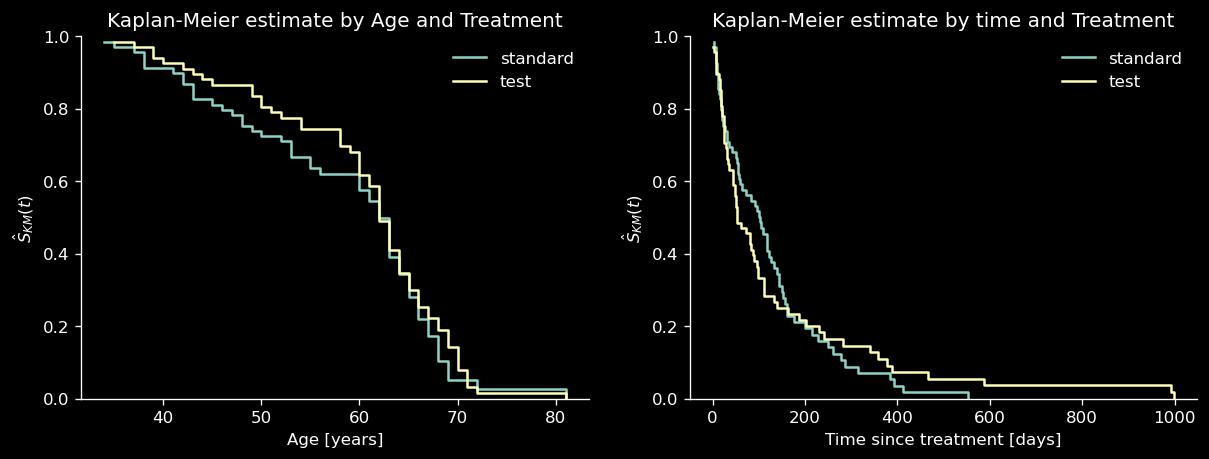

In [15]:

x_standard, y_standard = kaplan_meier_estimator(df.query('trt == 1')['status'].astype(bool), df.query('trt == 1')['age'])
x_test, y_test = kaplan_meier_estimator(df.query('trt == 2')['status'].astype(bool), df.query('trt == 2')['age'])

f, ax = plt.subplots(1, 2, dpi = 120, figsize = (12, 4))
# Standard treatment by age
ax[0].step(x_standard, y_standard, where="post", label = 'standard')
ax[0].step(x_test, y_test, where="post", label = 'test')
ax[0].set_ylim(0, 1)
clean_ax(ax[0])
ax[0].set_ylabel(r'$\hat{S}_{KM}(t)$')
ax[0].set_xlabel('Age [years]')
ax[0].set_title('Kaplan-Meier estimate by Age and Treatment')
ax[0].legend(loc = 'best', frameon = False)


x_standard, y_standard = kaplan_meier_estimator(df.query('trt == 1')['status'].astype(bool), df.query('trt == 1')['time'])
x_test, y_test = kaplan_meier_estimator(df.query('trt == 2')['status'].astype(bool), df.query('trt == 2')['time'])

# Standard treatment by age
ax[1].step(x_standard, y_standard, where="post", label = 'standard')
ax[1].step(x_test, y_test, where="post", label = 'test')
ax[1].set_ylim(0, 1)
clean_ax(ax[1])
ax[1].set_ylabel(r'$\hat{S}_{KM}(t)$')
ax[1].set_xlabel('Time since treatment [days]')
ax[1].set_title('Kaplan-Meier estimate by time and Treatment')
ax[1].legend(loc = 'best', frameon = False)
plt.show()

The above Kaplan-Meier estimates for the survival curves allow to study the effect of covariates on the survival function. This approach of splitting the dataset into smaller groups according to a variable is useful but not feasible when we want to consider more than a couple of variables, because subgroups will become very small very quickly. For this kind of situations we need models! BAM!

## Cox Proportional Hazard Models

This family of models introduced by Cox (1972) focuses on the hazard function insted of focusing on the survival function. The simplest member of this family of models is the **proportional hazards** model. For this model, the hazard at time $t$ for an individual with covariates $\vec{x}_i$ is assumed to be:
$$\lambda(t| \vec{x}_i) = \lambda_0(t)\exp \left\{ \vec{x}_i \cdot \vec{\beta}\right\},$$
where $\lambda_0 (t)$ is a baseline hazard function that describes the risk of individuals with $\vec{x}_i= 0$, who serve as a reference. The multiplicative term $\exp \{\vec{x}_i\cdot \vec{\beta}\}$ is the relative risk, a proportionate increase or reduction in risk that depends on the set of covariates $\vec{x}_i$. Note that this increase or reduction of risk does not change with time. In fact, the **proportional hazard assumption** is satisfied by two samples $\vec{x}_1$ and $\vec{x}_2$ when:
$$\dfrac{\lambda(t|\vec{x}_1)}{\lambda(t|\vec{x}_2)} = \dfrac{\lambda_0(t)\exp\{\vec{x}_1\cdot \vec{\beta}\}}{\lambda_0(t)\exp\{\vec{x}_2\cdot \vec{\beta}\}} = e^{(\vec{x}_1-\vec{x}_2)\cdot \vec{\beta}},$$
is constant with time. Taking the logarithm we obtain:
$$\log\lambda_i(t| \vec{x}_i) = \alpha_0(t)+ \vec{x}_i\cdot \vec{\beta},$$
which yields a linear model for the logarithm of the hazard. Returning to the expression for the hazard, we can integrate it to obtain the cumulative hazard functions:
$$\Lambda_i(t| \vec{x}_i) = \Lambda_0(t) \exp\{\vec{x}_i\cdot \vec{\beta}\},$$
exponentiating we obtain the survival functions:
$$S_i(t| \vec{x}_i)= S_0(t)^{\exp \{\vec{x}_i \cdot \vec{\beta}\}}.$$

Thus, the effect of the relative risk factor on the survival function is to raise it to a power. The likelihood of an event to be observed occuring for subket $i$ at time $t_i$ can be written as:
$$\mathcal{L}_i(\beta) = \dfrac{\lambda(t_i| \vec{x}_i)}{\sum_{j:t_j \geq t_i}\lambda (t_i| \vec{x}_j)},$$
that represents the probability of subject $i$ having an event at time $t_i$ among those at risk at time $t_i$. Note that the baseline hazard gets canceled out in the above expression, so we can write for the likelihood
$$\mathcal{L}(\beta) = \prod_{i}\dfrac{e^{\vec{x}_i\cdot \vec{\beta}}}{\sum_{j: t_j \geq t_i}e^{\vec{x}_j\cdot \vec{\beta}}}$$
The above expression has to be corrected for *tied* events, this is, when the number of deaths $d_i$ at time $t_i$ is greater than 1. This yields:
$$\mathcal{L}(\beta) = \prod_{i}\dfrac{e^{\vec{x}_i\cdot \vec{\beta}}}{\left(\sum_{j: t_j \geq t_i}e^{\vec{x}_j\cdot \vec{\beta}}\right)^{d_i}}.$$
> **Example:** Let us go back to the lung cancer dataset and try to estimate the risk scores and survival curve. 

In [16]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split

In [17]:
from sksurv.datasets import load_veterans_lung_cancer, get_x_y

# data_x, data_y = load_veterans_lung_cancer()

In [18]:
df['status_bool'] = df['status'].astype(np.bool_)

In [19]:
features = ['karno', 'diagtime', 'age', 'prior', 'trt', 'celltype']
targets = ['status_bool', 'time']

data_x, data_y = get_x_y(df[features+ targets], attr_labels= targets, pos_label=True)

from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()


estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [37]:
x_test = data_x_numeric.sample(5)

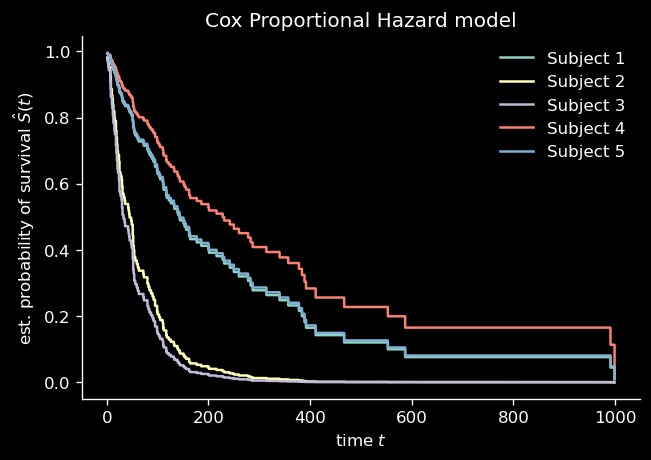

In [38]:
f, ax = plt.subplots(dpi = 120)
pred_surv = estimator.predict_survival_function(x_test)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    ax.step(time_points, surv_func(time_points), where="post",
             label="Subject %d" % (i + 1))
ax.set_ylabel("est. probability of survival $\hat{S}(t)$")
ax.set_xlabel("time $t$")
ax.legend(loc="best", frameon = False)
clean_ax(ax)
ax.set_title('Cox Proportional Hazard model')
plt.show()

## Exponential and Weibull models
Different kinds of proportional hazard models are obtained depending on the different choices for the baseline survival function. For example, we could (for some reason) set the baseline hazard function $\lambda_0(t) = \lambda_0$ to be a constant value. Then the hazard of subject $i$ at time $t$ reads:
$$\lambda_i(t| \vec{x}_i) = \lambda_0\, e^{\vec{x}_i\cdot \vec{\beta}}.$$

Another common model is obtained by assuming the death density function follows a *Weibull* distribution from which the survival function is:
$$S(t) = e^{-(\lambda t)^p},$$
and hazard function
$$\lambda(t) = p \lambda (\lambda t)^{p-1},$$
where $\lambda >0$ and $p > 0 $ are parameters. If $p=1$, this model reduces to the exponential model and has constant risk over time. If $p>1$, then the risk increases over time. If $p<1$, then the risk decreases with time. this can be seen by taking the log of the above expression:
$$\log \lambda(t) = \log(p) + \log(\lambda) + (p-1)\log(\lambda t).$$



### Time-Varying Covariates
The nature of the model allows for considering time dependent covariates.
Let $\vec{x}_i(t)$ denote the value of a covariate vector for subject $i$ at time (or duration) $t$. The proportional hazard model now reads:
$$\lambda(t|\vec{x}_i) = \lambda_0(t)\;e^{\vec{\beta} \cdot \vec{x}_i(t)}.$$

### Time-dependent "Effects"
The model can also be generalized so the coefficients $\beta(t)$ are now a function of time. Example: it is possible that cetain social characteristics might have a large impact on the hazard for children shortly after birth, but may have a relatively small impact later in life. So, we would like something like:
$$\lambda_i(t|\vec{x}_i) = \lambda_0(t)\; e^{\vec{\beta}(t) \cdot \vec{x}_i}.$$

### The General Hazard Rate Model
Naturally, we can let everything depend on time to obtain the most general version of a hazard rate model:
$$\lambda_i(t|\vec{x}_i) = \lambda_0(t)\;e^{\vec{\beta} (t) \cdot \vec{x}_i(t)}.$$
Or... more generally:
$$\lambda_i(t|\vec{x}_i) = \lambda_0(t)\; f_{ML}(\vec{x}_i,t).$$


# Discrete Time Models
There are cases where the time variable is actually a "discrete" value, which basically means that is not continuous. One example is using the age as a predictor for death risk. Having a discrete description is useful. In practice, it is the discrete description that is used to approximate the functions using our computers. 

Let the survival time $T$ be a discrete random variable that takes the values $t_1 < t_2 < \dots < t_n$ with density function:
$f(t_j) = f_j = \mathbb{P}(T = t_i).$
The survivor function at time $t_j$ is then:
$$S(t_j) = S_j = \mathbb{P}(T \geq t_j) = \sum_{k = j}^{\infty}f_k.$$
Next, we need to define the hazard at time $t_j$ as the conditional probability of dying at that time given that one has survived to that point, so that:
$$\lambda(t_j) = \lambda_j = \mathbb{P}(T = t_j | T \geq t_j)=  \dfrac{f_j}{S_j}.$$
Another result of interest in discrete time is that the survival function at time $t_j$ can be written in terms of the hazard at all prior times $t_1, \dots, t_{j-1}$ as:
$$S_j = (1-\lambda_1)(1- \lambda_2) \dots (1-\lambda_{j-1}),$$
which makes sense, since one needs to survive $t_1$, then one must survive $t_2$ given that has survived $t_1$, and so on, finally surviving $t_{j-1}$ up to that point.

# Measuring the Performance of Survival Models
Usual metrics such as RMSE or correlation might not be suitable for censored variables. The most frequently used evalution metric of survival models is the concordance index (c-index, c-statistic). It is a rank correlation between predicted risk scores $\hat{f}$ and observed time points $t$ that is closely related to Kendall's $\tau$. It is defined as the ratio of correctly ordered (concordant) pairs to comparable pairs. This is, two samples $i$ and $j$ are **comparable** if the sample with lower survival time $t$ experienced an event, i.e., if $t_j > t_i$ and $d_i=1$. A comparable pair is **concordant** if the estimated risk $\hat{f}$ by a survival model is higher for subjects with lower survival time, i.e., 
$$\hat{f}_i > \hat{f}_j \; \land t_j > t_i, $$
otherwise the pair is said to be **discordant**. Essentially, we are talking about the following quantity:
$$\boxed{\mathbb{P}(\hat{f}_i > \hat{f}_j| t_j > t_i) .}$$
[Harrell](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3079915/) proposed an estimator of this quantity and that is implemented in `scikit-survival`. Known as Harrell's concordance index, c-index or c-statistic. The interpretation is identicall to our usual ROC curve.

In [22]:
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw

In [23]:
prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["status_bool"], data_y["time"], prediction)
result[0]

0.7051340299863699

While Harrell’s concordance index is easy to interpret and compute, it has some shortcomings: 
1. it has been shown that it is too optimistic with increasing amount of censoring 
2. it is not a useful measure of performance if a specific time range is of primary interest (e.g. predicting death within 2 years).

The first point is addressed by a weighing procedure known as IPCW (Inverse Probability of Censoring Weights). 

The second issue is adressed by extending the well known ROC curve to possibly censored survival times. Given a time point $t$, we can estimate how well a predictive model can distinguishing subjects who will experience an event by time $t$ (sensitivity) from those who will not (specificity). The resulting AUC for this time-dependent cumulative/dynamic ROC curve is:
 $$\text{AUC}^{C,D}(t) = \mathbb{P}(\hat{f}_i > \hat{f}_j | T_i \leq t, T_j > t).$$
 An estimator for this quantity is implemented in `scikit-survival`, defined as:
 $$\widehat{AUC}(t) = \dfrac{\sum_{i=1}^{N}\sum_{j=1}^{N}\mathbb{I}_{t_j>t}\,\mathbb{I}_{t_i\leq t}\,\omega_i\, \mathbb{I}_{\hat{f}_i > \hat{f}_j}}{\left(\sum_{i = 1}^{N}\mathbb{I}_{t_i> t}\right)\left(\sum_{i = 1}^{N}\mathbb{I}_{t_j\leq t}\omega_i\right)},$$
where $\omega_i$ are inverse probability of censoring weights (IPCW).
To estimate IPCW, access to survival times from the training data is required to estimate the censoring distribution. Note that this requires that survival times survival_test lie within the range of survival times survival_train. This can be achieved by specifying times accordingly, e.g. by setting times[-1] slightly below the maximum expected follow-up time. IPCW are computed using the Kaplan-Meier estimator, which is restricted to situations where the random censoring assumption holds and censoring is independent of the features.
Finally, the function also provides a single summary measure that refers to the mean of the $\text{AUC}(t)$ over the time range $(\tau_1,\tau_2)$:
$$\widehat{\text{AUC}}(\tau_1, \tau_2) = \dfrac{1}{\hat{S}(\tau_1)- \hat{S}(\tau_2)}\int_{\tau_1}^{\tau_2}\widehat{\text{AUC}}(t)d\hat{S}(t),$$
where $\hat{S}(t)$ is the Kaplan-Meier estimator of the survival function.




In [24]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.datasets import load_flchain

from sklearn.impute import SimpleImputer

Let us load another built-in dataset from `scikit-survival`. The dataset has 7874 samples and 9 features:

>* age: age in years
>* sex: F=female, M=male
>* sample.yr: the calendar year in which a blood sample was obtained
>* kappa: serum free light chain, kappa portion
>* lambda: serum free light chain, lambda portion
>* flc.grp: the serum free light chain group for the subject, as used in the original analysis
>* creatinine: serum creatinine
>* mgus: whether the subject had been diagnosed with monoclonal gammapothy (MGUS)
>* chapter: for those who died, a grouping of their primary cause of death by chapter headings of the International Code of Diseases ICD-9
>* The endpoint is death, which occurred for 2169 subjects (27.5%).

In [25]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Let us treat some missing values

In [26]:
num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_test_imputed = imputer.transform(x_test.loc[:, num_columns])

We need to be a little bit careful when selecting the test data and time points we want to evaluate the ROC at, due to the estimator’s dependence on inverse probability of censoring weighting. First, we are going to check whether the observed time of the test data lies within the observed time range of the training data.

In [27]:
y_events = y_train[y_train['death']]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

When choosing the time points to evaluate the ROC at, it is important to remember to choose the last time point such that the probability of being censored after the last time point is non-zero. Here we use a more conservative approach by setting the upper bound to the 80% percentile of observed time points, because the censoring rate is quite large at 72.5%.

In [28]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


Text(0.5, 1.0, 'Time dependent AUC')

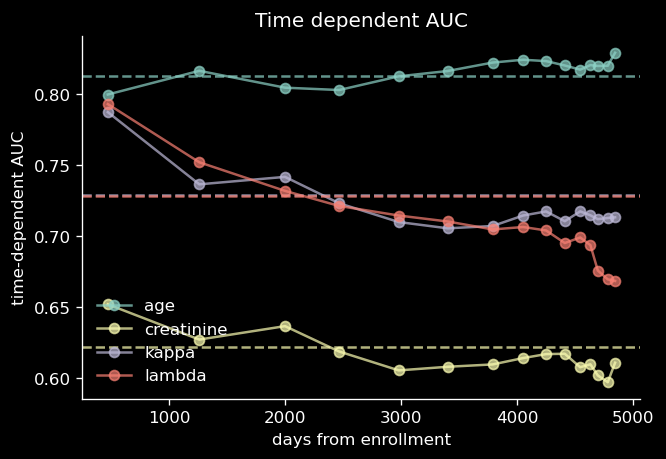

In [29]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None, ax = None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    if ax == None:
        plt.plot(times, auc, marker="o", color=color, label=label, alpha = 0.7)
        plt.xlabel("days from enrollment")
        plt.ylabel("time-dependent AUC")
        plt.axhline(mean_auc, color=color, linestyle="--", alpha = 0.7)
        plt.legend(loc = 'best', frameon = False)
    else:
        ax.plot(times, auc, marker="o", color=color, label=label, alpha = 0.7)
        ax.set_xlabel("days from enrollment")
        ax.set_ylabel("time-dependent AUC")
        ax.axhline(mean_auc, color=color, linestyle="--", alpha = 0.7)
        ax.legend(loc = 'best', frameon = False)
    


f, ax = plt.subplots(dpi = 120)

for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test_imputed[:, i], col, color="C{}".format(i), ax = ax)
    ret = concordance_index_ipcw(y_train, y_test, x_test_imputed[:, i], tau=times[-1])
    clean_ax(ax)
ax.set_title('Time dependent AUC')

The plot shows the estimated area under the time-dependent ROC at each time point and the average across all time points as dashed line.

We can see that age is overall the most discriminative feature, followed by $\kappa$ and $\lambda$ FLC. That fact that age is the strongest predictor of overall survival in the general population is hardly surprising (we have to die at some point after all). More differences become evident when considering time: the discriminative power of FLC decreases at later time points, while that of age increases. The observation for age again follows common sense. In contrast, FLC seems to be a good predictor of death in the near future, but not so much if it occurs decades later.

## Evaluating model's predictions
### Cox Proportional Hazards model



In [30]:
from sklearn.pipeline import make_pipeline

va_x, va_y = load_veterans_lung_cancer()

va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
                                                    va_x, va_y, test_size=0.2, stratify=va_y["Status"], random_state=0
                                                )

Fit the Cox prorportional hazard model to the train data:

In [31]:
cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(va_x_train, va_y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis())])

Using the test data, we want to assess how well the model can distinguish survivors from deceased in weekly intervals, up to 6 months after enrollment.

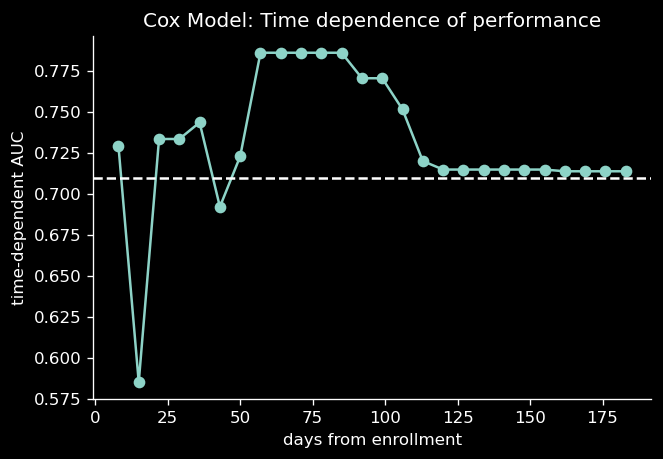

In [32]:
va_times = np.arange(8, 184, 7)
cph_risk_scores = cph.predict(va_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, cph_risk_scores, va_times)

f, ax = plt.subplots(dpi = 120)
ax.plot(va_times, cph_auc, marker="o")
ax.axhline(cph_mean_auc, linestyle="--")
ax.set_xlabel("days from enrollment")
ax.set_ylabel("time-dependent AUC")
ax.grid(False)
ax.set_title('Cox Model: Time dependence of performance')
clean_ax(ax)
plt.show()

The plot shows that the model is doing moderately well on average with an AUC of $\approx 0.72$ (dashed line). However, there is a clear difference in performance between the first and second half of the time range. The performance on the test data increases up to 56 days from enrollment, remains high until 98 days and quickly drops thereafter. Thus, we can conclude that the model is most effective in predicting death in the **medium-term**.

### Random Survival Forests
The downside of Cox proportional hazards model is that it can only predict a risk score that is independent of time (due to the built-in proportional hazards assumption). Therefore, a single predicted risk score needs to work well for every time point. In contrast, a Random Survival Forest does not have this restriction. So let’s fit such a model to the training data.  Details of the inner workings of Random Survival Forests can be found [here](https://arxiv.org/pdf/0811.1645.pdf).

In [33]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(OneHotEncoder(),
                    RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)
                    )
rsf.fit(va_x_train, va_y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('randomsurvivalforest',
                 RandomSurvivalForest(min_samples_leaf=7, random_state=0))])

For prediction, we do not call predict, which returns a time-independent risk score, but call predict_cumulative_hazard_function, which returns a risk function over time for each patient. We obtain the time-dependent risk scores by evaluating each cumulative hazard function at the time points we are interested in.

In [34]:
# Predict
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(va_x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

# Dynamic AUC
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, rsf_risk_scores, va_times)

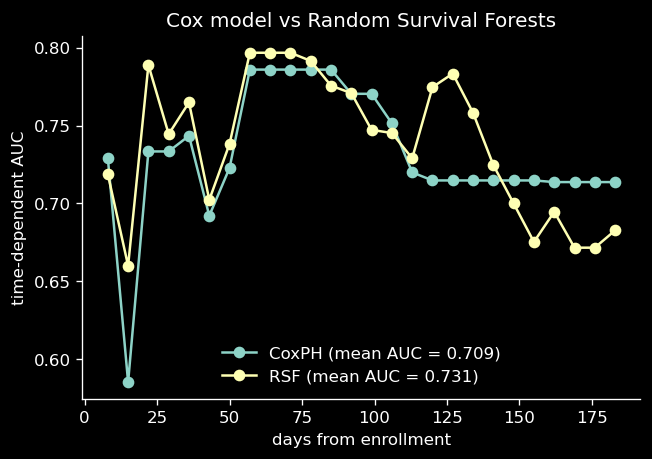

In [35]:
f, ax = plt.subplots(dpi = 120)

ax.plot(va_times, cph_auc, "o-", label="CoxPH (mean AUC = {:.3f})".format(cph_mean_auc))
ax.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
ax.set_xlabel("days from enrollment")
ax.set_ylabel("time-dependent AUC")
ax.legend(loc="lower center", frameon = False)
clean_ax(ax)
ax.set_title('Cox model vs Random Survival Forests')
plt.show()

Indeed, the Random Survival Forest performs slightly better on average, mostly due to the better performance in the intervals 25–50 days, and 112–147 days. Above 147 days, it actually is doing worse. This shows that the mean AUC is convenient to assess overall performance, but it can hide interesting characteristics that only become visible when looking at the AUC at individual time points.

## Conclusions and further references

IMHO Survival Analysis is about asking the right questions: 
* Does it make sense to tackle this or that problem as a usual classification problem?
* What are we trying to model?
* Is time an important variable for prediction?

There is a considerable amount of (open source) resources out there that are written in python such as [pySurvival](https://square.github.io/pysurvival/index.html) and [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html). The people at Loft made a clever use of XGBoost and some other techniques to tackle the survival analysis problem know as [XGBoost-survival-embeddings](https://github.com/loft-br/xgboost-survival-embeddings).
